In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim

In [2]:
torch.manual_seed(42)
BATCH_SIZE= 32

transform_aug= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
    brightness=0.5,  # Randomly adjust brightness by a factor between [max(0, 1-0.5), 1+0.5] = [0.5, 1.5]
    contrast=(0.8, 1.2),  # Randomly adjust contrast by a factor between 0.8 and 1.2
    saturation=0.3,  # Randomly adjust saturation by a factor between [max(0, 1-0.3), 1+0.3] = [0.7, 1.3]
    hue=(-0.1, 0.1))  # Randomly adjust hue by a factor between -0.1 and 0.1
])

train_dataset= torchvision.datasets.CIFAR10(root= './data', train= True, download= True, transform= transform_aug)
test_dataset= torchvision.datasets.CIFAR10(root= './data', train= False, download= True, transform= transform_aug)

train_loader= DataLoader(dataset= train_dataset, batch_size= BATCH_SIZE, shuffle= True)
test_loader= DataLoader(dataset= test_dataset, batch_size= BATCH_SIZE, shuffle= False)

class_names= train_dataset.classes

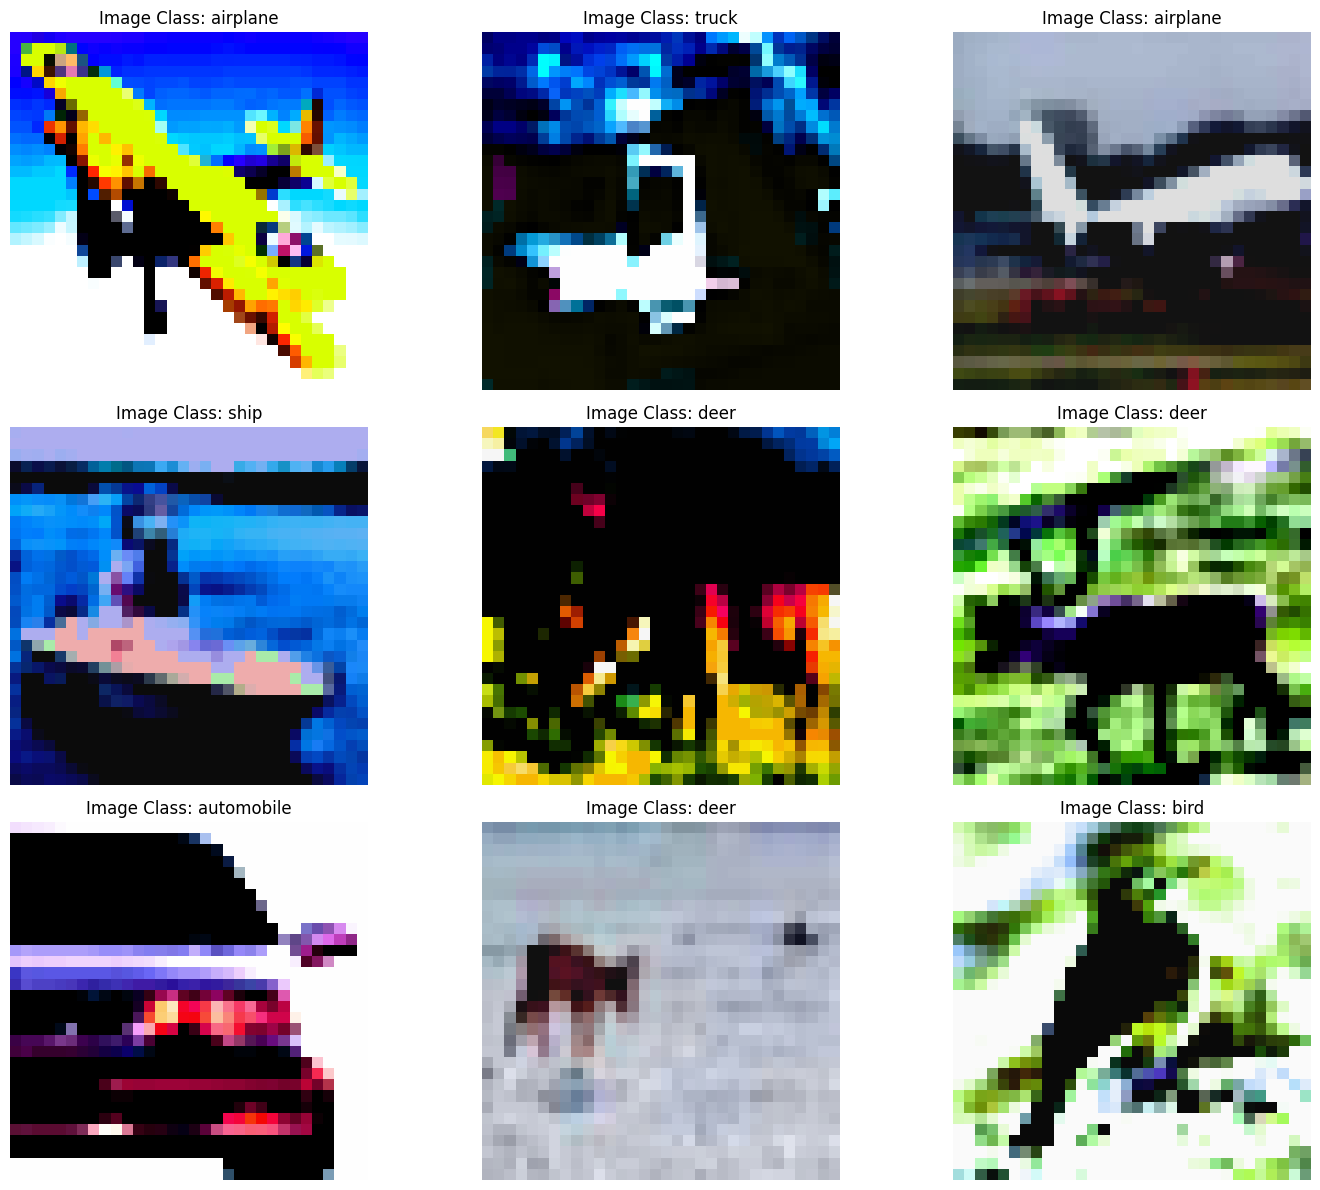

torch.Size([32, 3, 32, 32])

In [3]:
def display_images(images, labels, class_names, indices, n_rows= 3, n_cols= 3, figsize= (15,12)):
    fig, axes= plt.subplots(n_rows, n_cols, figsize= figsize)

    axes= axes.flatten()
    for i, idx in enumerate(indices):
        image= images[idx].permute(1,2,0).numpy()
        label= labels[idx].item()

        axes[i].imshow(image.squeeze())
        axes[i].axis(False)
        axes[i].set_title(f"Image Class: {class_names[label]}")
    plt.tight_layout()
    plt.show()
images, labels= next(iter(train_loader))
indices= [1,6, 16, 9, 7, 25, 29, 2, 4]
display_images(images, labels, class_names, indices)
images.shape

In [4]:
class BNConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size= 3, stride= 1, padding= 1, bias= False):
        super(BNConvBlock, self).__init__()
        self.conv= nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias= bias)
        self.bn= nn.BatchNorm2d(out_channels)
        self.relu= nn.ReLU(inplace= True)

    def forward(self, x):
        x= self.conv(x)
        x= self.bn(x)
        x= self.relu(x)
        return x

In [5]:
class BNResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride= 1):
        super(BNResidualBlock, self).__init__()
        self.conv1= nn.Conv2d(in_channels, out_channels, kernel_size= 3, stride= stride, padding= 1, bias= False)
        self.bn1= nn.BatchNorm2d(out_channels)
        self.relu= nn.ReLU(inplace= True)
        self.conv2= nn.Conv2d(out_channels, out_channels, kernel_size= 3, stride= 1, padding= 1, bias= False)
        self.bn2= nn.BatchNorm2d(out_channels)

        # Skip Connection
        self.shortcut= nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual= self.shortcut(x)
        output= self.conv1(x)
        output= self.bn1(output)
        output= self.relu(output)
        output= self.conv2(output)
        output= self.bn2(output)
        output+= residual
        output= self.relu(output)
        return output

In [6]:
class ResNet18(nn.Module):
    def __init__(self, num_classes= 10):
        super(ResNet18, self).__init__()
        self.apply(self._initialize_weights)

        # Initial Conv and Pooling
        self.conv1= nn.Conv2d(3, 64, kernel_size= 3, stride= 1, padding=1, bias= False)
        self.bn1= nn.BatchNorm2d(64)
        self.relu= nn.ReLU(inplace= True)
        self.maxpool= nn.MaxPool2d(kernel_size= 2, stride= 2, padding= 0)


        # ResNet-18 Stages (2 blocks per stage)
        self.stage1 = self._make_stage(BNResidualBlock, 64, 64, 2, stride=1)    # 2 blocks
        self.stage2 = self._make_stage(BNResidualBlock, 64, 128, 2, stride=2)    # 2 blocks
        self.stage3 = self._make_stage(BNResidualBlock, 128, 256, 2, stride=2)   # 2 blocks
        self.stage4 = self._make_stage(BNResidualBlock, 256, 512, 2, stride=2)   # 2 blocks

        # Final Layers
        self.avgpool= nn.AdaptiveAvgPool2d((1,1))
        self.fc= nn.Linear(512, num_classes)

        # Tracking variables
        self.stages= [self.stage1, self.stage2, self.stage3, self.stage4]
        self.activations_sum= [[0.0] * len(stage) for stage in self.stages]
        self.gradients_sum= [[0.0] * len(stage) for stage in self.stages]
        self.layer_counts= [[0] * len(stage) for stage in self.stages]

        # Attach hooks
        self._attach_hooks()

    def _initialize_weights(self, m):
        """Apply Kaiming init"""
        if isinstance(m, nn.Conv2d):
            nn.init_kaiming_normal_(m.weight, mode= 'fan_out', nonlinearity= 'relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        if isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init_constant_(m.bias, 0)

    def _make_stage(self, block, in_channels, out_channels, num_blocks, stride):
        layers = []
        # First block may downsample
        layers.append(block(in_channels, out_channels, stride))
        # Remaining blocks - use out_channels as input
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def _attach_hooks(self):
        """Attach forward and backward hooks"""
        for stage_idx, stage in enumerate(self.stages):
            for layer_idx, layer in enumerate(stage):
                # Forward hook for activations
                layer.register_forward_hook(
                    lambda module, input, output, idx= (stage_idx, layer_idx):
                    self._record_activation(idx, output)
                )
                # Backward hook for gradients
                layer.register_full_backward_hook(
                    lambda module, grad_input, grad_output, idx= (stage_idx, layer_idx):
                    self._record_gradient(idx, grad_output[0])
                )
    def _record_activation(self, idx, output):
        """Record activation L2-Norm"""
        stage_idx, layer_idx= idx
        self.activations_sum[stage_idx][layer_idx]+= torch.norm(output.detach(), p= 2).item()
        self.layer_counts[stage_idx][layer_idx]+= 1

    def _record_gradient(self, idx, gradient):
        """Record gradient L2-Norm"""
        stage_idx, layer_idx= idx
        self.gradients_sum[stage_idx][layer_idx]+= torch.norm(gradient.detach(), p= 2).item()
        self.layer_counts[stage_idx][layer_idx]+= 1

    def reset_tracking(self):
        """Reset tracking vars"""
        for stage in self.activations_sum:
            for i in range(len(stage)):
                stage[i]= 0.0
        for stage in self.gradients_sum:
            for i in range(len(stage)):
                stage[i]= 0.0
        for stage in self.layer_counts:
            for i in range(len(stage)):
                stage[i]= 0

    def get_average_activations_per_stage(self):
        """Calculate average activation L2-norm per stage"""
        return [
            sum(layer_sums) / max(sum(counts), 1)
            for layer_sums, counts in zip(self.activations_sum, self.layer_counts)
        ]
    def get_average_gradients_per_stage(self):
        """Calculate average gradient L2-norm per stage"""
        return [
            sum(layer_sums) / max(sum(counts), 1)
            for layer_sums, counts in zip(self.gradients_sum, self.layer_counts)
        ]

    def forward(self, x):
        """Forward pass"""
        # Initial conv and pool
        x= self.conv1(x)
        x= self.bn1(x)
        x= self.relu(x)
        x= self.maxpool(x)

        # Stages
        x= self.stage1(x)
        x= self.stage2(x)
        x= self.stage3(x)
        x= self.stage4(x)

        # Final layers
        x= self.avgpool(x)
        x= torch.flatten(x, 1)
        x= self.fc(x)

        return x



In [7]:
class PlainModel(nn.Module):
    def __init__(self, num_classes= 10, dropout_rate= 0.5):
        super(PlainModel,self).__init__()
        self.apply(self._initialize_weights)

        # Initial Pooling and Convolution
        self.conv1= nn.Conv2d(in_channels= 3, out_channels= 64, kernel_size= 3, stride= 1, padding= 1, bias= False)
        self.bn1= nn.BatchNorm2d(64)
        self.relu= nn.ReLU(inplace= True)
        self.maxpool= nn.MaxPool2d(kernel_size= 2, stride= 2, padding= 0)

        # Create stages using ConvBlock
        # Create stages using ConvBlock (reduced depth)
        self.stage1 = self._make_stage(BNConvBlock, 64, 64, 2, stride=1)    # 2 blocks
        self.stage2 = self._make_stage(BNConvBlock, 64, 128, 2, stride=2)     # 2 blocks
        self.stage3 = self._make_stage(BNConvBlock, 128, 256, 2, stride=2)    # 2 blocks
        self.stage4 = self._make_stage(BNConvBlock, 256, 512, 2, stride=2)     # 2 blocks

        # Final Layers
        self.avgpool= nn.AdaptiveAvgPool2d((1, 1))
        self.dropout= nn.Dropout(p= dropout_rate)
        self.fc= nn.Linear(512, num_classes)

        # Tracking Vars
        self.stages= [self.stage1, self.stage2, self.stage3, self.stage4]
        self.activations_sum= [[0.0] * len(stage) for stage in self.stages]
        self.gradients_sum= [[0.0] * len(stage) for stage in self.stages]
        self.layer_counts= [[0] * len(stage) for stage in self.stages]

        # Attach hooks to all layers
        self._attach_hooks()

    def _initialize_weights(self, m):
        """Apply Kaiming init to conv layers"""
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode= 'fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        if isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        # if isinstance(m, nn.Linear):
        #     nn.init.kaiming_normal_(m.weight, mode= 'fan_in', nonlinearity= 'relu')
        #     if m.bias is not None:
        #         nn.init.constant_(m.bias, 0)
    def _make_stage(self, block, in_channels, out_channels, num_blocks, stride):
        """Create Stage with multiple Conv blocks"""
        # First block may downsample
        layers= []
        layers.append(block(in_channels, out_channels, stride= stride))
        # Remaining Blocks
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride= 1))
        return nn.Sequential(*layers)

    def _attach_hooks(self):
        """Attach forward and backward hooks to all layers in all stages"""
        for stage_idx, stage in enumerate(self.stages):
            for layer_idx, layer in enumerate(stage):
                # Forward hook for activations
                layer.register_forward_hook(
                    lambda module, input, output, idx=(stage_idx, layer_idx):
                    self._record_activation(idx, output)
                )
                # Backward hook for gradients
                layer.register_full_backward_hook(
                    lambda module, grad_input, grad_output, idx=(stage_idx, layer_idx):
                    self._record_gradient(idx, grad_output[0])
                )
    def _record_activation(self, idx, output):
        """Record activation L2-norm for a layer"""
        stage_idx, layer_idx= idx
        self.activations_sum[stage_idx][layer_idx]+= torch.norm(output.detach(), p= 2).item()
        self.layer_counts[stage_idx][layer_idx]+= 1

    def _record_gradient(self, idx, gradient):
        """Record gradient L2-Norm for a layer"""
        stage_idx, layer_idx= idx
        self.gradients_sum[stage_idx][layer_idx]+= torch.norm(gradient.detach(), p= 2).item()
        self.layer_counts[stage_idx][layer_idx]+= 1

    def reset_tracking(self):
        for stage in self.activations_sum:
            for i in range(len(stage)):
                stage[i]= 0.0
        for stage in self.gradients_sum:
            for i in range(len(stage)):
                stage[i]= 0.0
        for stage in self.layer_counts:
            for i in range(len(stage)):
                stage[i]= 0

    def get_average_activations_per_stage(self):
        """Calculate average activation L2-Norm per stage"""
        return [
            sum(layer_sums) / max(sum(counts), 1)
            for layer_sums, counts in zip(self.activations_sum, self.layer_counts)
        ]

    def get_average_gradients_per_stage(self):
        """Calculate average activation L2-Norm per stage"""
        return [
            sum(layer_sums) / max(sum(counts), 1)
            for layer_sums, counts in zip(self.gradients_sum, self.layer_counts)
        ]

    def forward(self, x):
        # Initial Conv and Pooling
        x= self.conv1(x)
        x= self.bn1(x)
        x= self.relu(x)
        x= self.maxpool(x) # Downsample to 16x16

        # Stages
        x= self.stage1(x)
        x= self.stage2(x)
        x= self.stage3(x)
        x= self.stage4(x)

        # Final Layers
        x= self.avgpool(x)
        x= torch.flatten(x, 1)
        x= self.fc(x)

        return x


In [8]:
def train_eval_model(model,
                     train_loader,
                     test_loader,
                     optimizer,
                     num_epochs,
                     device,
                     loss_fn,
                     scheduler= None):
    # Logging and Early Stopping Vars
    train_loss_history= []
    val_loss_history= []
    train_acc_history= []
    val_acc_history= []
    activation_norm_history= []
    gradient_norm_history= []
    patience= 3
    best_val_accuracy= 0.0
    epochs_with_no_improvement= 0
    min_delta= 0.1

    for epoch in range(num_epochs):
        model.train()
        running_train_loss= 0.0
        train_correct= 0
        train_total= 0
        model.reset_tracking()

        for images, labels in train_loader:
            # Move data to device
            images, labels= images.to(device), labels.to(device)

            # Forward Pass + Loss Calc
            preds= model(images)
            loss= loss_fn(preds, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_train_loss+= loss.item()

            # Calculate Training Accuracy
            _, predicted= torch.max(preds.data, 1)
            train_total+= labels.size(0)
            train_correct+= (predicted == labels).sum().item()

        # Log activation/gradient std
        activation_norm_history.append(model.get_average_activations_per_stage())
        gradient_norm_history.append(model.get_average_gradients_per_stage())

        model.eval()
        running_val_loss= 0.0
        val_correct= 0
        val_total= 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels= images.to(device), labels.to(device)
                preds= model(images)
                loss= loss_fn(preds, labels)

                running_val_loss+= loss.item()

                _, predicted= torch.max(preds.data, 1)
                val_total+= labels.size(0)
                val_correct+= (predicted == labels).sum().item()

        running_val_loss/= len(test_loader)
        running_train_loss/= len(train_loader)

        train_acc= (train_correct / train_total) * 100
        val_acc= (val_correct / val_total) * 100

        if val_acc >= best_val_accuracy + min_delta:
            best_val_accuracy= val_acc
            epochs_with_no_improvement= 0
        else:
            epochs_with_no_improvement+= 1

        # Log history and print
        train_loss_history.append(running_train_loss)
        val_loss_history.append(running_val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} ")
        print("-" * 10)
        print(f"Train Loss: {running_train_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {running_val_loss:.4f}")
        print(f"Val Accuracy: {val_acc:.2f}%")
        print("Activation Norms:", activation_norm_history[-1])
        print("Gradient Norms:", gradient_norm_history[-1])
        print("-" * 50)

        if epochs_with_no_improvement >= patience:
            print(f"Early Stopping Triggered at Epoch {epoch + 1}. No improvement after {patience} Epochs")
            break

        if scheduler:
            scheduler.step()
    epochs= [epoch for epoch in range(1, len(train_loss_history) + 1)]
    return {
    "epochs": epochs,
    "train_loss_history": train_loss_history,
    "val_loss_history": val_loss_history,
    "train_acc_history": train_acc_history,
    "val_acc_history": val_acc_history,
    "activation_norm_history": activation_norm_history,
    "gradient_norm_history": gradient_norm_history
    }

In [9]:
torch.manual_seed(42)
LEARNING_RATE_ADAM= 0.001
LEARNING_RATE_SGD= 0.1
NUM_EPOCHS= 10
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn= nn.CrossEntropyLoss()

plain_model= PlainModel()
plain_model_optimizer= optim.SGD(plain_model.parameters(), LEARNING_RATE_SGD, momentum= 0.9, weight_decay= 5e-4)
plain_model_scheduler= optim.lr_scheduler.CosineAnnealingLR(plain_model_optimizer, T_max= NUM_EPOCHS)

resnet_model= ResNet18()
resnet_model_optimizer= optim.SGD(resnet_model.parameters(), LEARNING_RATE_SGD, momentum= 0.9, weight_decay= 5e-4)
resnet_model_scheduler= optim.lr_scheduler.CosineAnnealingLR(resnet_model_optimizer, T_max= NUM_EPOCHS)


print(f"Control Plain Deep CNN W/SGD Training Start...")
print(f"-"*80)
plain_model.to(device)
plain_model_metrics= train_eval_model(model= plain_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= plain_model_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= plain_model_scheduler)
print(f"-"*80)
print(f"Resnet Deep CNN W/SGD Training Start...")
print(f"-"*80)
resnet_model.to(device)
resnet_model_metrics= train_eval_model(model= resnet_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= resnet_model_optimizer,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn,
                                scheduler= resnet_model_scheduler)
print(f"-"*80)

Control Plain Deep CNN W/SGD Training Start...
--------------------------------------------------------------------------------
Epoch 1/10 
----------
Train Loss: 1.8969
Train Accuracy: 29.32%
Val Loss: 1.7650
Val Accuracy: 35.95%
Activation Norms: [184.65477231367993, 133.97163293244208, 94.70531408708979, 44.9878091571122]
Gradient Norms: [0.012618419989091877, 0.011030245879101189, 0.012185534617590395, 0.0368270964308994]
--------------------------------------------------
Epoch 2/10 
----------
Train Loss: 1.5284
Train Accuracy: 44.74%
Val Loss: 1.6078
Val Accuracy: 45.66%
Activation Norms: [110.81480457991724, 72.10880632089334, 45.9344406304875, 25.72386894939957]
Gradient Norms: [0.03678199783401351, 0.03947210906911224, 0.045147291367953396, 0.05718725949575885]
--------------------------------------------------
Epoch 3/10 
----------
Train Loss: 1.3668
Train Accuracy: 51.37%
Val Loss: 1.5100
Val Accuracy: 48.53%
Activation Norms: [109.63582317476767, 61.85576305523639, 32.9957

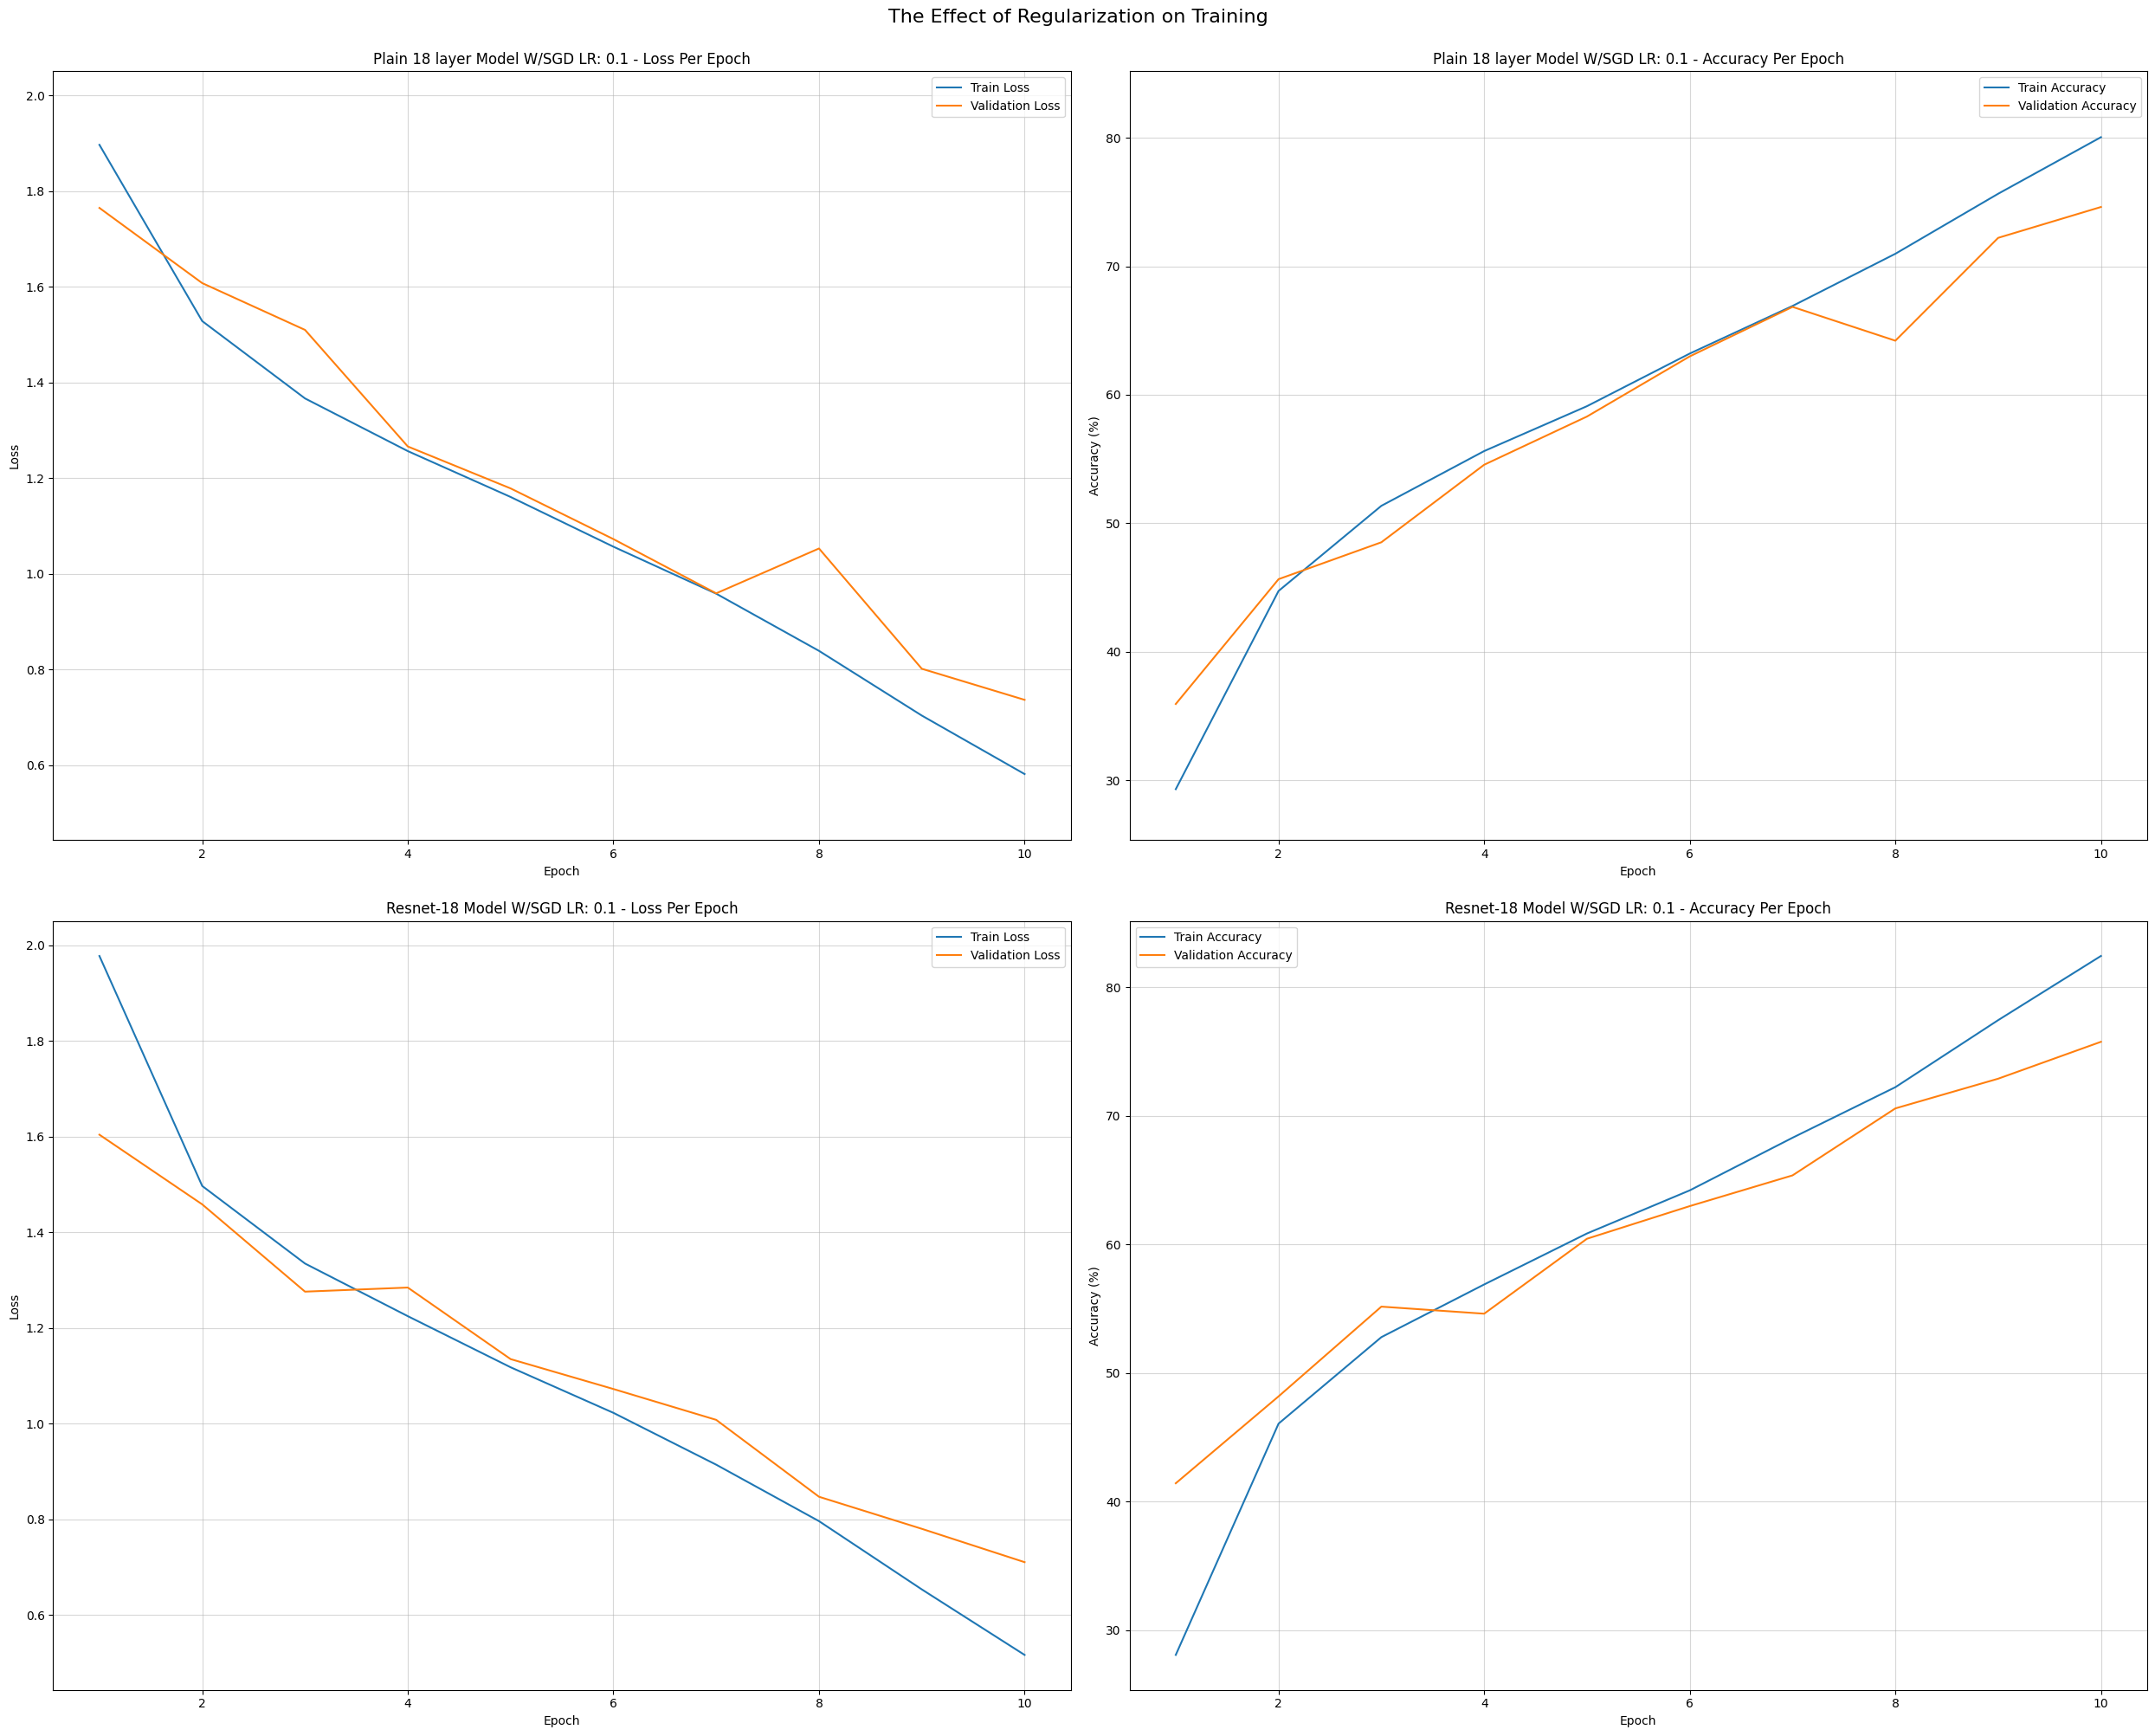

In [11]:
# Create figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(25, 20))

# Data to plot (model metrics)
models_data = [
    (plain_model_metrics, f"Plain 18 layer Model W/SGD LR: {LEARNING_RATE_SGD}"),
    (resnet_model_metrics, f"Resnet-18 Model W/SGD LR: {LEARNING_RATE_SGD}")
]

# Precompute global min and max for loss and accuracy
all_losses = []
all_accuracies = []
for metrics, _ in models_data:
    all_losses.extend(metrics["train_loss_history"])
    all_losses.extend(metrics["val_loss_history"])
    all_accuracies.extend(metrics["train_acc_history"])
    all_accuracies.extend(metrics["val_acc_history"])

# Add 5% padding to the ranges
loss_padding = (max(all_losses) - min(all_losses)) * 0.05
acc_padding = (max(all_accuracies) - min(all_accuracies)) * 0.05

# Set consistent y-axis limits for all plots
for i in range(2):
    # Left column (loss plots)
    axes[i, 0].set_ylim(min(all_losses) - loss_padding, max(all_losses) + loss_padding)

    # Right column (accuracy plots)
    axes[i, 1].set_ylim(min(all_accuracies) - acc_padding, max(all_accuracies) + acc_padding)

# Create plots for each model
for i, (metrics, title) in enumerate(models_data):
    # Left plot (loss)
    ax_left = axes[i, 0]
    ax_left.set_title(f"{title} - Loss Per Epoch")
    ax_left.grid(True, alpha=0.5)
    ax_left.set_xlabel("Epoch")
    ax_left.set_ylabel("Loss")
    p1 = ax_left.plot(metrics["epochs"], metrics["train_loss_history"], label='Train Loss')
    p2 = ax_left.plot(metrics["epochs"], metrics["val_loss_history"], label='Validation Loss')
    ax_left.legend()

    # Right plot (accuracy)
    ax_right = axes[i, 1]
    ax_right.set_title(f"{title} - Accuracy Per Epoch")
    ax_right.grid(True, alpha=0.5)
    ax_right.set_xlabel("Epoch")
    ax_right.set_ylabel("Accuracy (%)")
    p3 = ax_right.plot(metrics["epochs"], metrics["train_acc_history"], label='Train Accuracy')
    p4 = ax_right.plot(metrics["epochs"], metrics["val_acc_history"], label='Validation Accuracy')
    ax_right.legend()

# Add overall title and adjust layout
fig.suptitle(f"The Effect of Regularization on Training",
             fontsize=16, y=1.0)
fig.tight_layout(h_pad=2.0, w_pad=1.5)

plt.show()